워드클라우드와 텍스트 마이닝

colab 한글과
설치 후 메뉴 런타임 -> 런타임 다시 시작

In [1]:
# 구글 코랩 한글
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (7,131 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

# 구글 드라이브 연동   

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/colab/dataanalysis

Mounted at /content/drive
/content/drive/MyDrive/colab/dataanalysis


# JPype 설치  
- python에서 java 라이브러리를 이요할 수 있도록 설치한다.

In [2]:
# http://www.lfd.uci.edu/~gohlke/pythonlibs/#jpype
# 아래 부분 바로 실행하면 jpype설치됨
!pip install -U "jpype1<1.1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 32.8 MB/s eta 0:00:00


In [3]:
# 한글을 사용하기 위해 세종사전을 이용
!pip install konlpy
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 63.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### KoNLPY(코엔엘파이)  
- KoNLPy에서는 대한민국 헌법 말뭉치인 kolaw와 국회법안 말뭉치인 kobill을 제공한다.  

### import   

In [4]:
## 기본
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#데이터 전처리
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

In [5]:
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.4.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.4
aiosignal                     1.3.1
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        6.0.0
blis

# 데이터 가져오기

In [7]:
#utf-8 ' codec cant't decode byte 0xb9 in positiob 0 : invalid start byte
df =pd.read_csv('./data/review.csv', encoding='cp949')
df.head()

,번호,재학생구분,학년/학기,학과,성별,text
0,65,대학,1,인문계열,여,1학기 때 책 읽으려고 갔는데 먼지가 있었어요. 그래서 책상에 먼지가 없었으면 좋겠어요.
1,78,대학,3,사회계열,여,KC대학교도서관 재건축해주세요
2,100,대학,1,사회계열,여,개인스터디할공간이 필요
3,129,대학,4,인문계열,여,"건물 재건축 및 교체, 내부 리모델링"
4,37,대학,2,인문계열,남,공부를 할 수 있는 시설이 개선되었으면 좋겠습니다


In [8]:
df.shape

(59, 6)

In [9]:
# 데이터 전처리 과정에서 데이터 탐색 과정이 필요하다.
# 컬럼, 데이터 변수 등등 파악 필요
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   번호      59 non-null     int64 
 1   재학생구분   59 non-null     object
 2   학년/학기   59 non-null     int64 
 3   학과      59 non-null     object
 4   성별      59 non-null     object
 5   text    59 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.9+ KB


#명사단어 추출

#1. 세종사전 실행

In [10]:
# 각각 품사를 나눠주고, 형태에 따라 태그를 붙여야 함. 명사, 형용사 등등
# 이 과정을 해준것이 세종사전
from konlpy.tag import Okt # 트위터
twitter = Okt()

# 2. 단어 리스트 만들기

In [11]:
word_list=[]
word_list=df['text']

In [12]:
word_list

0     1학기 때 책 읽으려고 갔는데 먼지가 있었어요. 그래서 책상에 먼지가 없었으면 좋겠어요.
1                                      KC대학교도서관 재건축해주세요
2                                          개인스터디할공간이 필요
3                                  건물 재건축 및 교체, 내부 리모델링
4                           공부를 할 수 있는 시설이 개선되었으면 좋겠습니다
5     공부할수있는쾌적한 공간을 마련해주세요. 그저 좁은 공간에 책만 꽉 차서 책이 믾은 ...
6     논문 열람 가능한 사이트 riss를 학교와 연계해서 학생들이 이용할 수 있게 해주세...
7     대출불가도서를 대여해주던지 복사기를 고쳐주세요.. 대여도 안되고 복사도 잘안되서 돈...
8                  대학원 전공과 관련된 국내외 참고도서도 많이 구비하였으면 합니다.
9                                       더 나아진 도서관을 기대해요
10    도서관 2층 들어서자마자 있는 컴퓨터 공간 외 다른 공간들의 공기가 너무 탁합니다....
11                                         도서관 건물 시설 개설
12                        도서관 리모델링을 했으면 좋겠다. 너무 낙후되어있다.
13                                     도서관 책장이 너무 부실합니다
14    도서관같은 공간의 경우에는 사람을 끌어들이는 힘이 굉장히 중요하다고 생각하는데, 그...
15         도서관규모에비해직원수가많아서 직원1명이면충분함. 근로생들이 대출반납정리다하니..
16                                           도서관리모델링필요!
17    도서관에 간호학 전공 공부를 할 수 있는 다양한 자료가 있었으면 좋겠습니다.

# 3 형태소 분리 및 품사태깅

In [14]:
sentences_tag=[]
for sentence in word_list:
  morph = twitter.pos(sentence)
  sentences_tag.append(morph)
print(morph)

[('해당', 'Noun'), ('학기', 'Noun'), ('에', 'Josa'), ('쓰는', 'Verb'), ('전', 'Modifier'), ('공책', 'Noun'), ('등', 'Noun'), ('을', 'Josa'), ('구비', 'Noun'), ('하고', 'Josa'), (',', 'Punctuation'), ('그', 'Noun'), ('외', 'Noun'), ('에도', 'Josa'), ('최신', 'Noun'), ('도서', 'Noun'), ('들', 'Suffix'), ('이', 'Josa'), ('들어왔으면', 'Verb'), ('좋겠다', 'Adjective')]


# 4 명사만 추출

In [17]:
noun_list=[]
for sentence in sentences_tag:
  for word, tag in sentence:
    if tag in['Noun']:
      noun_list.append(word)

# 5명사가 두 문자 이상만 추출

In [18]:
len(noun_list)

618

In [19]:
len(noun_list)

noun_list=[n for n in noun_list if len(n)>1]
noun_list[:10]

['학기', '먼지', '책상', '먼지', '대학교', '도서관', '재건축', '개인', '스터디', '공간']

#6단어 카운트

In [20]:
counts = Counter(noun_list)
tags = counts.most_common(30) # 30개만 가져옴
print(len(tags))
tags

30


[('도서관', 36),
 ('공간', 28),
 ('공부', 17),
 ('시설', 12),
 ('학교', 12),
 ('학생', 11),
 ('도서', 11),
 ('이용', 10),
 ('환경', 9),
 ('최신', 9),
 ('생각', 8),
 ('자료', 8),
 ('열람', 7),
 ('조금', 7),
 ('학습', 6),
 ('개선', 5),
 ('다른', 5),
 ('먼지', 4),
 ('개인', 4),
 ('건물', 4),
 ('관련', 4),
 ('우리', 4),
 ('부분', 4),
 ('학기', 3),
 ('스터디', 3),
 ('모델링', 3),
 ('마련', 3),
 ('대학', 3),
 ('저희', 3),
 ('전공', 3)]

# Worldcolud

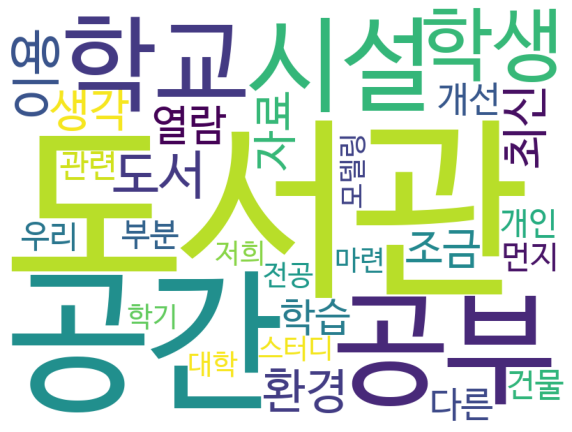

In [23]:
wordcloud = WordCloud(font_path='NanumBarunGothic', background_color='white', width=800, height=600)
colud = wordcloud.generate_from_frequencies(dict(tags))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(colud)
plt.show()

In [ ]:
# 데이터를 가지고 머신러닝을 해야한다고~